## Chapter 12: Introduction to nonlinear learning

# 12.3  Features, functions, and nonlinear unsupervised learning

In this Section we introduce the general framework of nonlinear unsupervised learning. Since there are such a wide variety of unsupervised learning models (see Chapter 11), and we want to keep things as elementary as we can in this Section, here we will focus our attention exclusively on how to extend perhaps the most important linear unsupervised learner to the nonlinear setting: the PCA autoencoder (detailed in Section 11.2). In future Chapters we will look at particular examples of how to extend other unsupervised methods such as K-Means.

In [12]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import unsupervised_library as unlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
optimizers = optlib.optimizers

basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np
import numpy as npo

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import matplotlib.pyplot as plt
from matplotlib import gridspec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 12.3.1  Modeling principles of the linear and nonlinear autoencoder

In Section 11.2 we discussed the PCA autoencoder, the fundamental cost function for PCA that leads to the classic orthogonal PCA solution (described in Section 11.2.3).  The autoencoder cost function  

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

is parameterized by the $N\times K$ matrix $\mathbf{C}$ that will act as our recovered basis upon minimization.  As discussed in Section 11.2, this cost is called the *autoencoder* because with it we learn both a proper *encoding* $\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$ and *decoding* $\mathbf{C}\mathbf{w}_p = \mathbf{C}\mathbf{C}^T\mathbf{x}_p$ for a set of data points simultaneously in terms of themselves.     

In preperation for the nonlinear extension of this scheme - which we will use to determine proper *nonlinear manifolds* for an input dataset - we will explicitly break up the two linear operations  $\mathbf{C}\mathbf{C}^T\mathbf{x}_p$ into an explicit *encoding* and *decoding* step.  We have our `encoder` function $f_{\text{e}}$

\begin{equation}
f_{\text{e}}\left(\mathbf{x}\right) = \mathbf{C}^T \mathbf{x}
\end{equation}

and `decoder` function $f_{\text{d}}$


\begin{equation}
f_{\text{d}}\left(\mathbf{w}\right) = \mathbf{C} \mathbf{w}
\end{equation}

We can then write our two linear operations on the input with this function notation as

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p
\end{equation}

where note here that notationally speaking we have left off dependency on internal parameters with the aim of keeping our formulae simple and more understandable, so e.g., here to make each function visibally dependent on the parameters $\mathbf{C}$ we would write $f_{\text{d}}\left(\mathbf{x},\mathbf{C}\right)$ and $f_{\text{e}}\left(\mathbf{x},\mathbf{C}\right)$.

We can then write the autoencoder cost function with this more general function notation as

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \,f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

This sort of mathematical notation carries over almost directly to `Python`, as we show below.  Here we process the entire dataset $\mathbf{X}$ in one operation (which is more effecient in `Python` than explicitly looping over the points).  Notice in both implementations - as opposed to the notation used above - we input `C` as well as the data.

In [13]:
# a linear encoder function
def encoder(X,C):
    return np.dot(C.T,X)

# a linear decoder function
def decoder(W,C):
    return np.dot(C,W)

In order to wrap up these two functions we can then use our typical `model` function, as shown below.  Running this on a single $\mathbf{x}$ produces the entire computation $f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right)$.

In [14]:
# a model function wrapping up our linear encoding/decoding schemes
def model(X,C):
    # encode the input
    W = encoder(X,C)
    
    # decode the encoding
    a = decoder(W,C)
    return a

To tune these parameters properly we can then minimize the `autoencoder` function below using e.g., gradient descent.

In [15]:
# an implementation of the least squares cost function for linear regression
def autoencoder(C):
    cost = np.sum((model(X,C) - X)**2)
    return cost/float(X.shape[1])

#### <span style="color:#a50e3e;">Example 1. </span> Linear PCA using the autoencoder 

Here we re-enact an experiment showing how to use the standard linear autoencoder first shown in Section 11.4, employing the organizatinoal style detailed above, to find the best one dimensional subspace for the two dimensional dataset shown below.

<IPython.core.display.Javascript object>


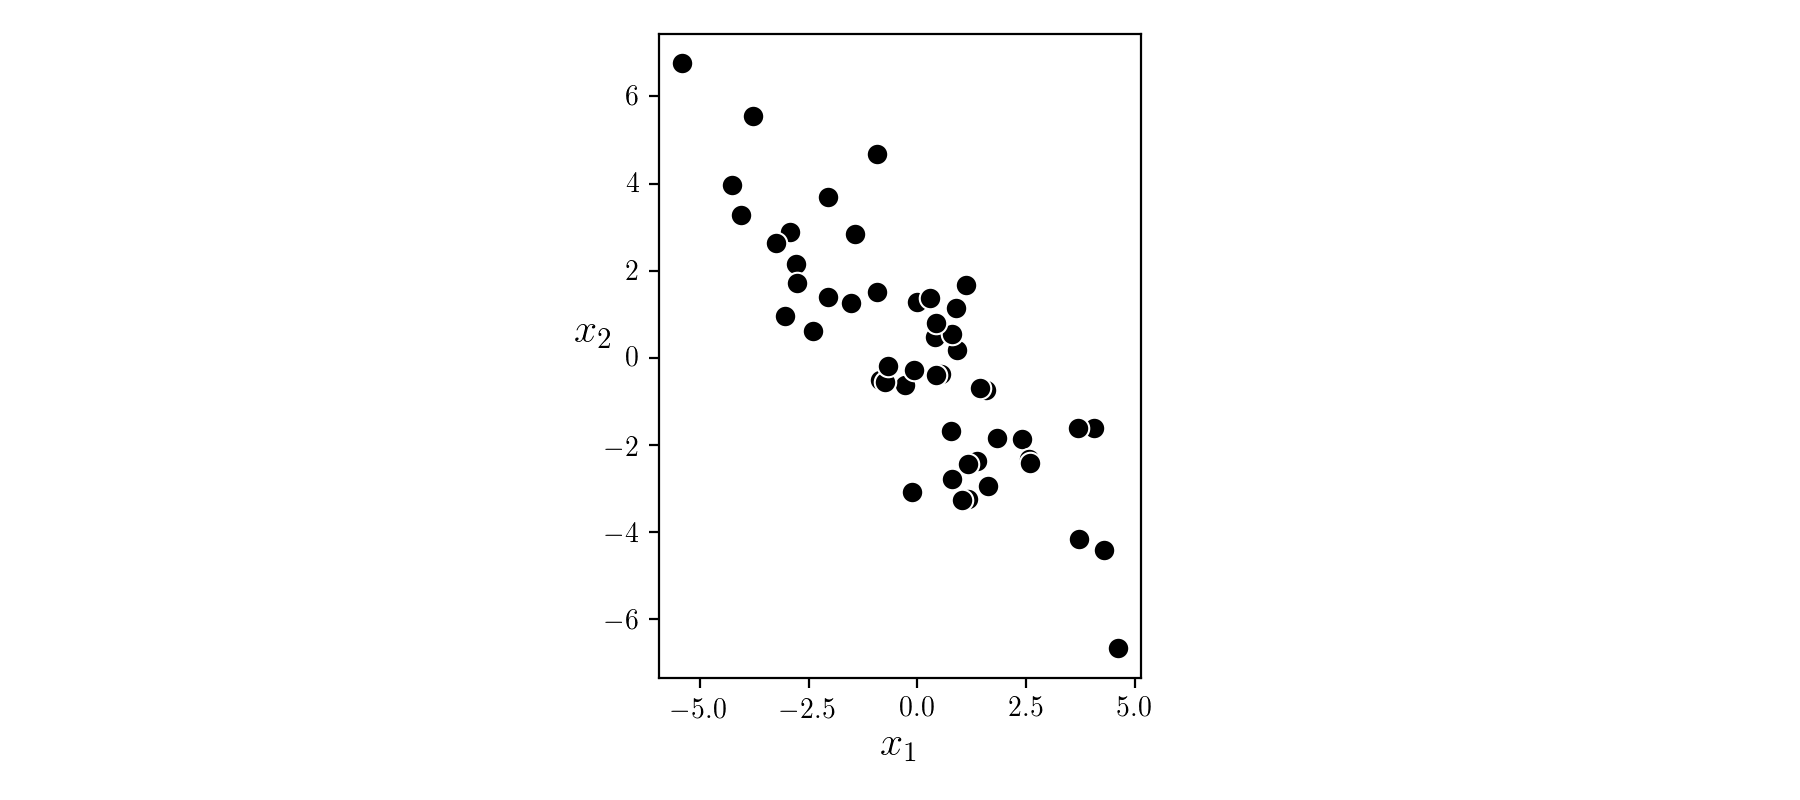

In [16]:
# load in a dataset to learn a PCA basis for via the autoencoder
X = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w');

In visually examining this dataset it does indeed look like it could be reasonably represented using a *linear* manifold or subspace (which in this case is clearly a line).  Because of this we can use our linear `encoder` and `decoder` functions defined above.

Using gradient descent we then minimize the autoencoder cost, finding the best one dimensional subspace for this two-dimensional dataset.

In [17]:
# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-2); max_its = 1000; C = 0.1*np.random.randn(2,1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

Shown below in the top row is (left panel) the original data and the principal component recovered (shown as a red arrow), the encoded version (middle panel) and decoded version (right panel) of the input data along with the subspace spanned by the recovered basis vector.  In the bottom row show the manifold recovered - i.e., here shown as a black line with red outline for visualization purposes - and illustrate how points in the space are attracted to the recovered manifold as vector field with arrows colored according to their distance to the linear subspace.

<IPython.core.display.Javascript object>


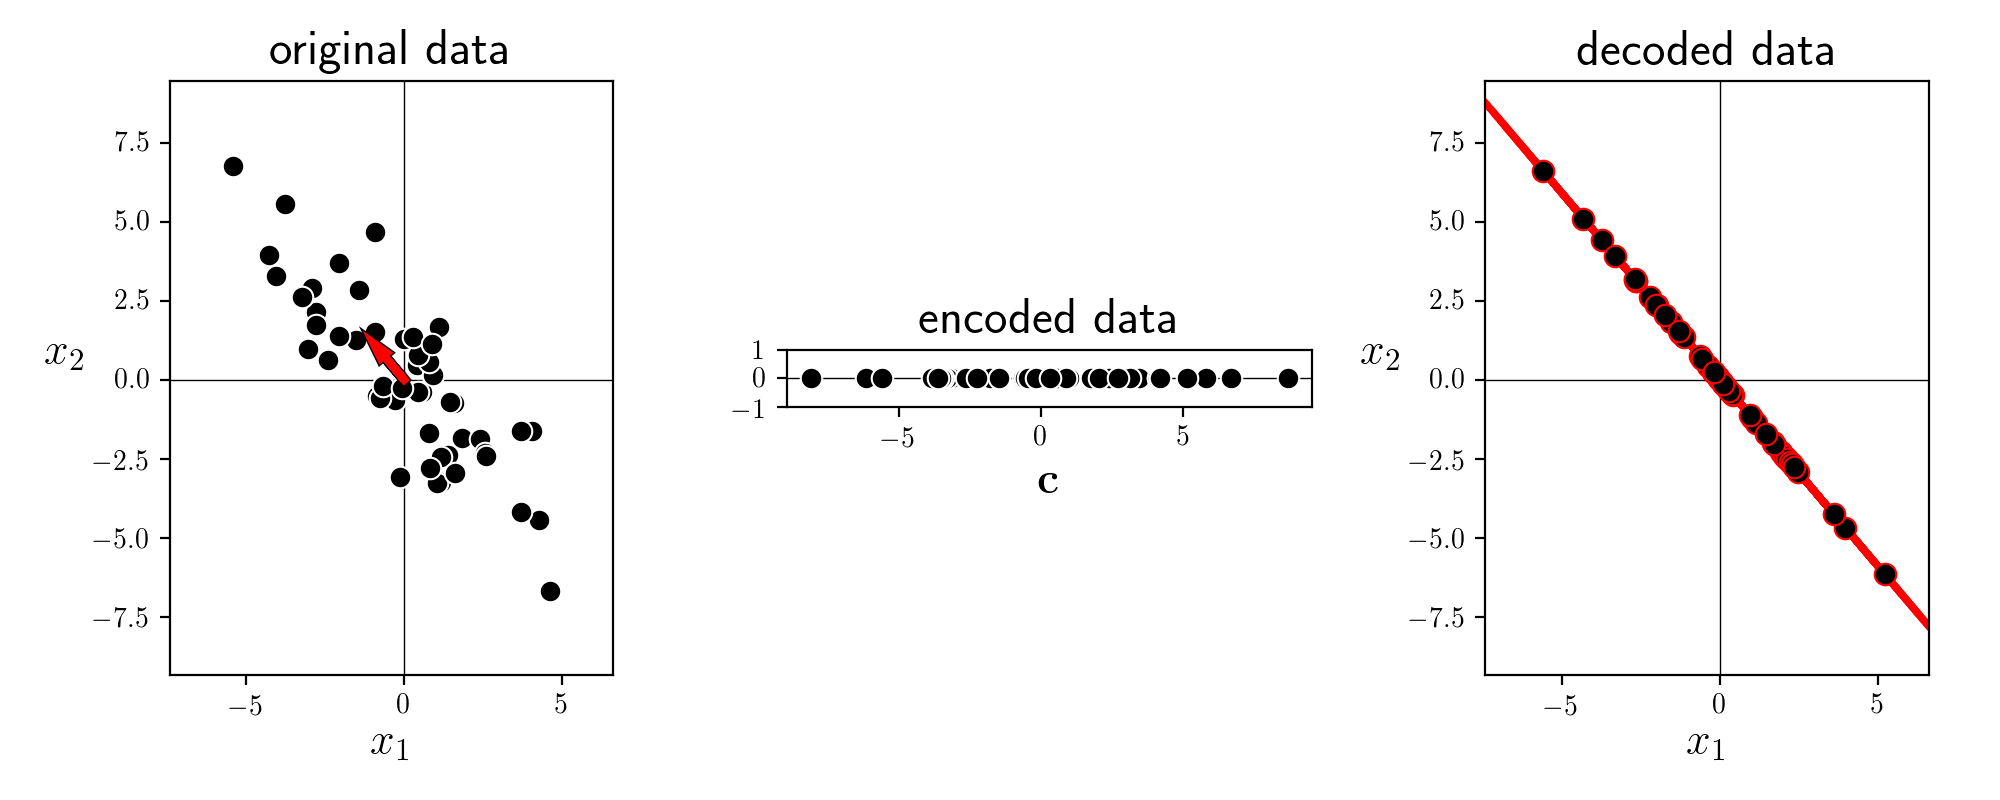

1


<IPython.core.display.Javascript object>


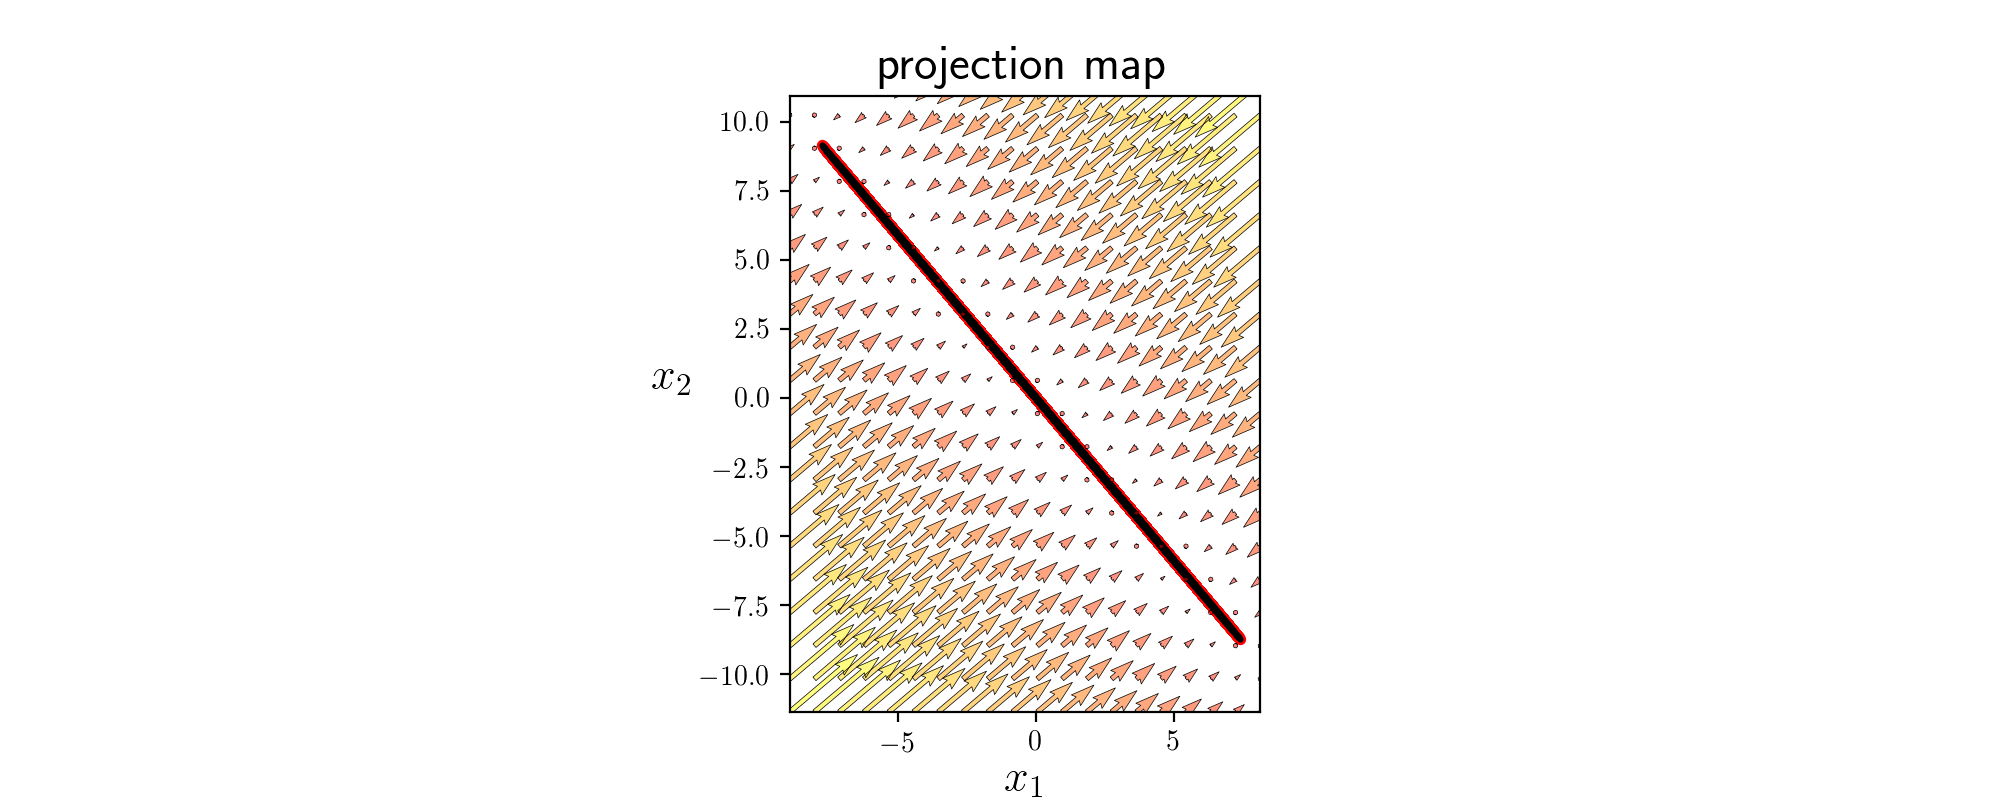

In [18]:
# plot results
unlib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,show_pc = True,scale = 150,encode_label = r'$\mathbf{c}$',projmap = True)

---

Now just as we discussed in the previous Sections, where we described how to extend linear regression and classification to the general nonlinear case, here the fact the `encoder` and `decoder` above are *linear* does not refect a limitation of the autoencoder framework but simply *modeling choice of ours*.  We (originally) aimed to uncover the best *linear* subspaces for an input dataset because this is the simplest model to work with, and allows us to flush out important technical details.  However nothing about the autoencoder framework itself limits us to using *nonlinear* encoding/decoding functions, and thus prevents us from extending the idea in order to uncover the best *nonlinear* manifold for a given set of input data.

In general we want an encoder / decoder pair so that

\begin{equation}
f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) \approx \mathbf{x}_p.
\end{equation}

In other words - we aim for our encoder / decoder pair to learn an *identity function* for our given input. 

To make this extension we can introduce any two *parameterized* nonlinear functions / feature transformations: one for `encoding`  $\,\,f_{\text{e}}\left(\mathbf{x}\right)$ and one for `decoding` $ f_{\text{d}}\left(\mathbf{v}\right)$ (again leaving off explicit dependency on internal parameters with both functions for notational simplicity).  If we swap out our linear encoding/decoding schemes for these more general functions we have a general autoencoder function

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \,f_{\text{d}}\left(\,f_{\text{e}}\left(\mathbf{x}_p\right)\right) - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

where we have denoted by $\mathbf{w}$ the entire set of parameters of both the `encoder` $f_{\text{e}}$ and `decoder` $f_\text{d}$, e.g., in the linear case $\mathbf{w} = \mathbf{C}$.  Note we could also use a linear combination of nonlinear feature transformations for both `encoder` and `decoder` as well.

## 12.1.3  Introductory examples of nonlinear PCA via the autoencoder

To implement the nonlinear autoencoder in `Python` we can virtually re-use most of the code framework we employed in the linear case - including our `model` and `autoencoder` functions.  We only need to slightly modify the `model` function to take in a generally larger set of parameters - since each of our encoding/decoding functions can in general can have unique sets of parameters.  To keep things as general as possible we will rewrite the `model` function as shown below.  Note here we input a single list `w` which contains two arrays: its first array `w[0]` contains the parameters of our encoder while the second array `w[1]` contains parameters of the decoder.  This is just one way to implement a more general model, you might like a different user-interface.

In [21]:
# a general model wrapping up our encoder/decoder
def model(X,w):
    # encode the input
    v = encoder(X,w)
    
    # decode the encoding
    a = decoder(v,w)
    return a

Thus - in short - practically speaking to use the nonlinear autoencoder we need only define `encoder` and `decoder` functions, since the above `autoencoder` cost function implementation is always the same regardless of the dataset / nonlinearities used and `model` functions will always be more or less the same.

In [22]:
# an implementation of the least squares cost function for linear regression
def autoencoder(w):
    cost = np.sum((model(X,w) - X)**2)
    return cost/float(X.shape[1])

#### <span style="color:#a50e3e;">Example 2. </span> Finding a circular subspace via the autoencoder

Iin this example we illustrate how to design encoder

<IPython.core.display.Javascript object>


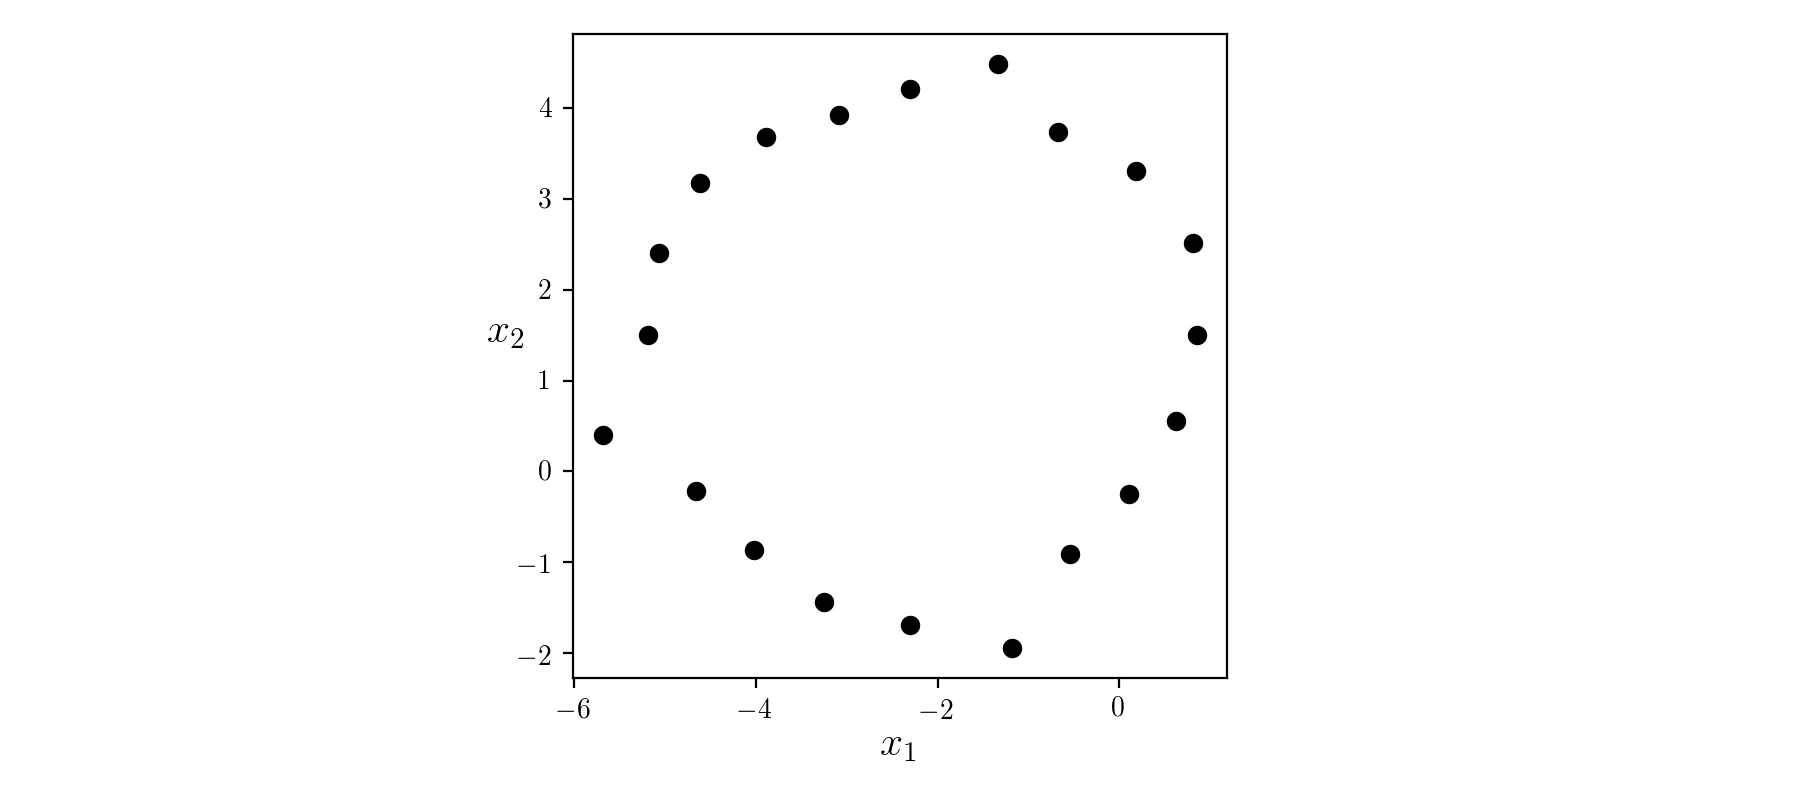

In [23]:
# import data
X = np.loadtxt(datapath + 'circle_data.csv',delimiter=',')

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')

First we have our custom arctangent function.

In [24]:
def my_arctan(x,y):
    v = y/x
    if x > 0:
        return np.arctan(v)
    elif x < 0 and y >= 0:
        return np.arctan(v) + np.pi
    elif x < 0 and y < 0:
        return np.arctan(v) - np.pi
    elif x==0 and y > 0:
        return np.pi*0.5
    elif x==0 and y < 0:
        return -np.pi*0.5  

Now our `encoder` and `decoder`.

In [25]:
def encoder(x,w):
    a = x - w[0]     
    b = []
    for i in range(a.shape[1]):
        b.append(my_arctan(a[0][i],a[1][i]))
    b = np.array(b)[np.newaxis,:]
    return b

def decoder(v,w):
    a = w[1][:,np.newaxis]*np.vstack((np.cos(v),np.sin(v))) + w[0][:,np.newaxis]
    return a

Now we make a run of gradient descent to tune the encoder/decoder parameters.

<IPython.core.display.Javascript object>


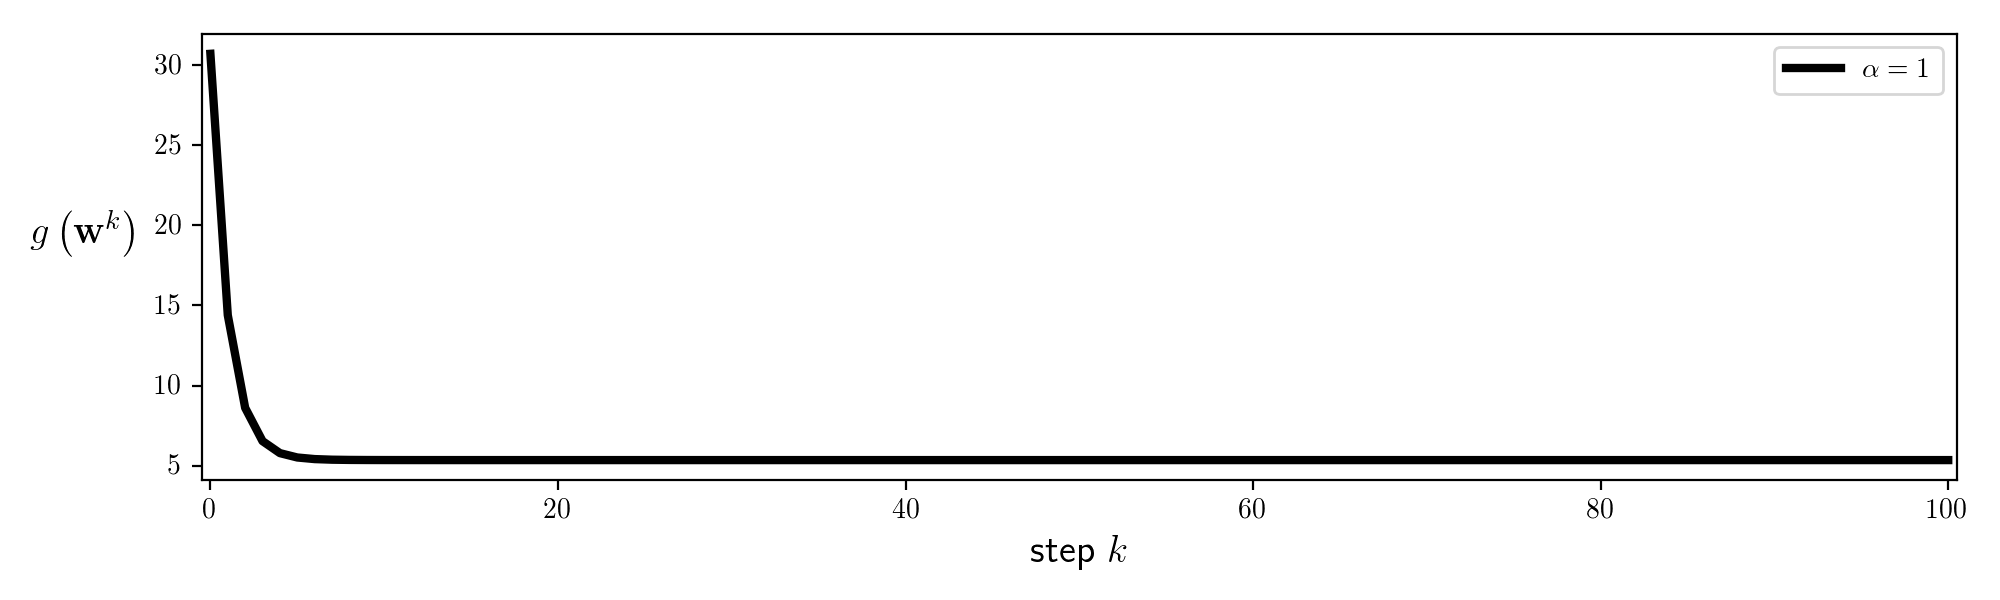

In [26]:
scale = 0.1
w = [scale*np.random.randn(2,1),scale*np.random.randn(1)];

# tune pca least squares cost
g = autoencoder;

# tune pca least squares cost
alpha_choice = 10**(-1); max_its = 100; 
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

Now we can plot out manifold learned, as well sa the projection map below.

<IPython.core.display.Javascript object>


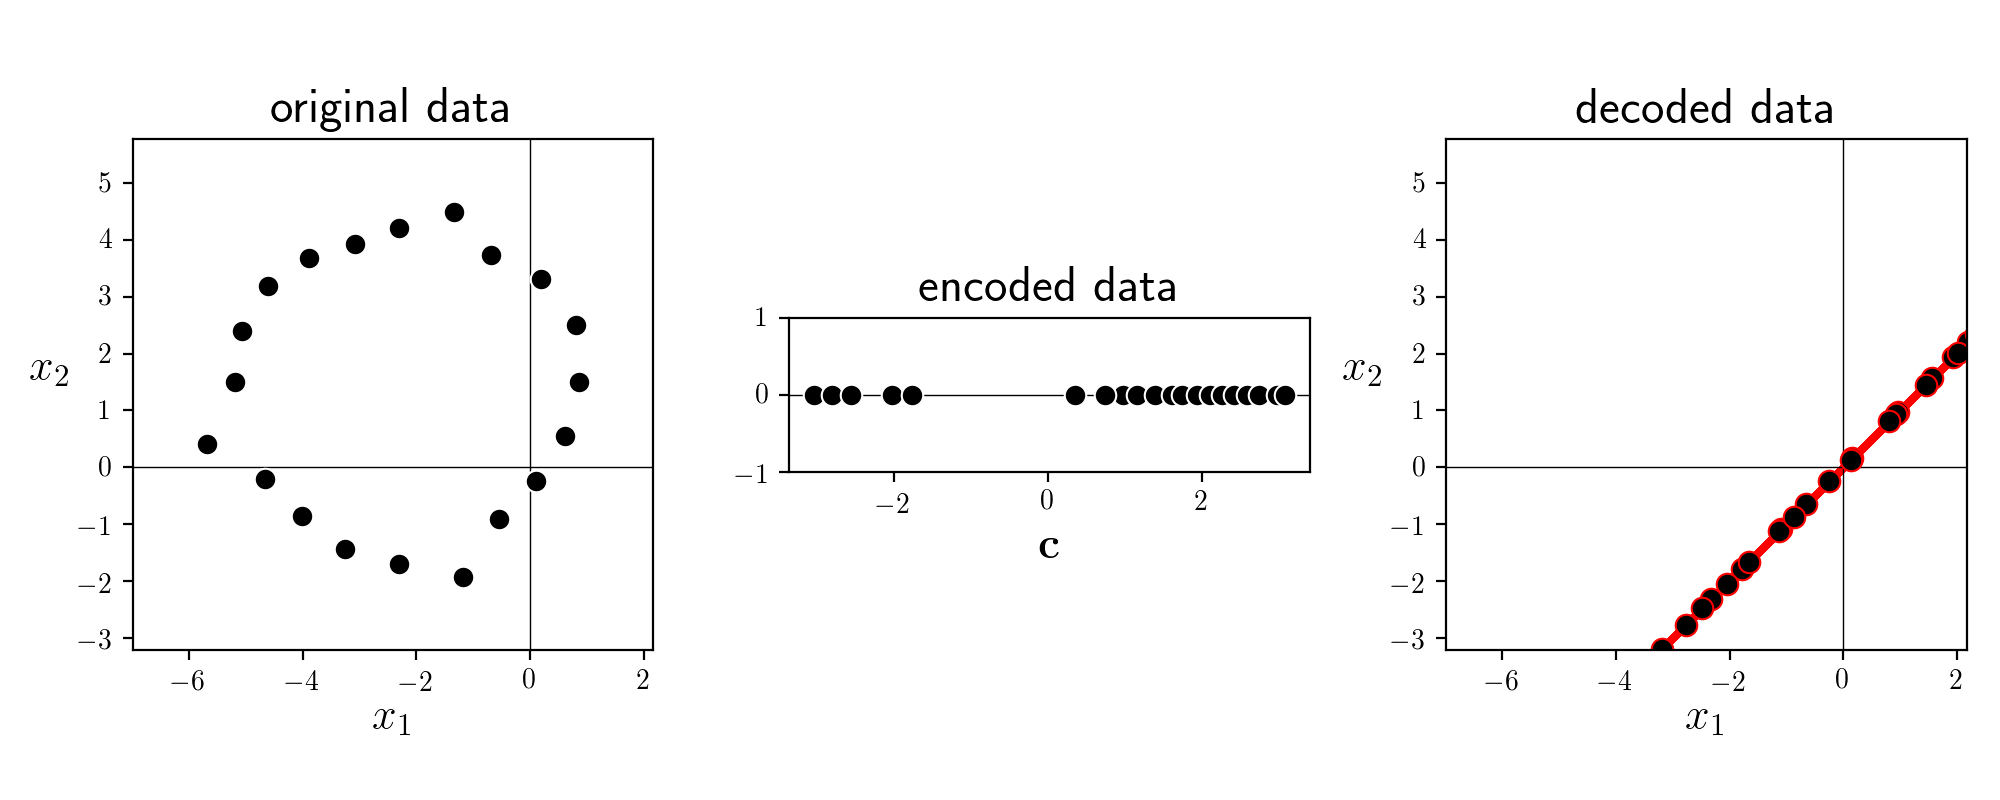

In [29]:
# plot results
unlib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,encoder=encoder,decoder=decoder,show_pc = False,scale = 55,encode_label = r'$\mathbf{c}$',projmap = False)